<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Pretraining BERT Models**


Estimated time needed: **60** minutes


In this hands-on lab, you will learn how to build a BERT model from scratch using PyTorch.


## __Table of contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Background">Background</a>
        <ol>
            <li><a href="#Introduction-to-pretraining">Introduction to pretraining</a></li>
            <li><a href="#Pretraining-objectives">Pretraining objectives</a></li>
            <li><a href="#Pretraining-a-BERT-model">Pretraining a BERT model</a></li>
        </ol>
    </li>
    <li><a href="#Loading-data">Loading data</a></li>
    <li><a href="#Model-creation">Model creation</a></li>
    <li><a href="#Evaluation">Evaluation</a></li>
    <li><a href="#Training">Training</a></li>
    <li><a href="#Inference">Inference</a></li>
    <li>
        <a href="#Exercises">Exercises</a>
        <ol>
            <li><a href="#Exercise-1:-Next-Sentence-Prediction-(NSP)-with-BERT">Exercise 1: Next Sentence Prediction (NSP) with BERT</a></li>
            <li><a href="#Exercise-2:-Masked-Language-Modeling-(MLM)-with-BERT">Exercise 2: Masked Language Modeling (MLM) with BERT</a></li>
        </ol>
    </li>
</ol>


## Objectives

In this interactive guide, you will delve into the core components of encoder models, with a spotlight on 'Baby BERT', a streamlined variant of the BERT model. This notebook aims to:

- **Demystify tokenization**: Introduce the critical first step in processing text for Natural Language Processing (NLP) — tokenization. We'll learn how to convert raw text into a format that's amenable to machine processing.
- **Decode encoder models**: Shed light on the structure and function of encoder models, particularly how they capture and process the complexities of language.
- **Pretraining dynamics**: Walk through the pretraining phase of 'Baby BERT' on a bespoke dataset, showcasing how language models are equipped to understand context and meaning.
- **Task-specific proficiency**: Assess 'Baby BERT's capabilities in handling sentence sequencing and word prediction challenges through Next Sentence Prediction (NSP) and Masked Language Modeling (MLM).
- **Performance analysis**: Evaluate how well our model performs these tasks, providing insights into its linguistic comprehension and ability to predict accurately.


## Setup


### Installing required libraries
The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:
> Note: After executing the 'pip install' cell restart the kernel and execute the subsequent cells.


In [1]:
!pip install --no-cache-dir numpy==1.26.4 pandas==2.2.1
!pip install --no-cache-dir torch==2.3.0 torchtext==0.18.0 transformers==4.35.2
!pip install --no-cache-dir matplotlib==3.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.17.0+cpu requires torch==2.2.0, but you have torch 2.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 127.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 504.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 127.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existin

### Importing required libraries

_It is recommended you import all required libraries in one place (here):_


In [1]:
import torch
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Transformer
from transformers import BertTokenizer
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchtext.vocab import Vocab,build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import IMDB
import random
from itertools import chain
import pandas as pd
from copy import deepcopy
import csv
import json
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import get_linear_schedule_with_warmup

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


/opt/conda/lib/python3.12/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/opt/conda/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable

## Background
### Introduction to pretraining


Pretraining involves training a model on a large corpus of unlabeled text to capture general language patterns and semantic relationships. Pretrained models can then be fine-tuned on specific downstream NLP tasks, such as sentiment analysis, question answering, or machine translation.

The motivation behind pretraining transformers is to address the limitations of traditional approaches that require significant amounts of labeled data for each specific task. Pretraining leverages the abundance of unlabeled text data available on the internet and facilitates transfer learning, where knowledge learned from one task can be transferred to aid in solving other related tasks.

Pretraining objectives play a crucial role in training transformers. For example, masked language modeling (MLM) involves randomly masking some words in a sentence and training the model to predict the masked words based on the surrounding context. This objective helps the model learn contextual understanding and fill in missing information. Another objective called next sentence prediction (NSP) involves predicting whether two sentences are consecutive or randomly chosen from the corpus, enabling the model to learn sentence-level relationships.

In the next sections of this lab, you will delve deeper into pretraining objectives. By the end of this lab, you will have a solid understanding of pretraining tasks for BERT models.


### Pretraining objectives

Pretraining objectives are crucial components of the pretraining process for transformers. These objectives define the tasks that the model is trained on during the pretraining phase, allowing it to learn meaningful contextual representations of language. Two commonly used pretraining objectives are masked language modeling (MLM) and next sentence prediction (NSP).

1. Masked Language Modeling (MLM):
   Masked language modeling involves randomly masking some words in a sentence and training the model to predict the masked words based on the context provided by the surrounding words(i.e., words that appear either before or after the masked word). The objective is to enable the model to learn contextual understanding and fill in missing information.

   Here's how MLM works:
   - Given an input sentence, a certain percentage of the words are randomly chosen and replaced with a special [MASK] token.
   - The model's task is to predict the original words that were masked, given the context of the surrounding words.
   - During training, the model learns to understand the relationship between the masked words and the rest of the sentence, effectively capturing the contextual information.

2. Next Sentence Prediction (NSP):
   Next sentence prediction involves training the model to predict whether two sentences are consecutive in the original text or randomly chosen from the corpus. This objective helps the model learn sentence-level relationships and understand the coherence between sentences.

   Here's how NSP works:
   - Given a pair of sentences, the model is trained to predict whether the second sentence follows the first sentence in the original text or if it is randomly selected from the corpus.
   - The model learns to capture the relationships between sentences and understand the flow of information in the text.

   NSP is particularly useful for tasks that involve understanding the relationship between multiple sentences, such as question answering or document classification. By training the model to predict the coherence of sentence pairs, it learns to capture the semantic connections between them.

It's important to note that different pretrained models may use variations or combinations of these objectives, depending on the specific architecture and training setup.


### Pretraining a BERT model
Pretraining a BERT(Bidirectional Encoder Representations from Transformers) model is a complex and time-consuming process that requires a large corpus of unlabeled text data and significant computational resources. However, you provide with a simplified exercise to demonstrate the steps involved in pretraining a BERT model using the Masked Language Modeling (MLM) as well as the Next Sentence Prediction (NSP) objectives.

You will be instructed to:
- Create train and test dataloaders from dataset
- Pretrain BERT using an MLM task
- Pretrain BERT using an NSP task
- Evaluate the trained model


## Loading data
Let's load the CSV files created in the data preparation lab.


In [2]:
%%bash
# Remove any earlier instance of the dataset loaded
if [ -d "bert_dataset" ]; then
    rm -rf bert_dataset
fi

In [3]:
!wget -O BERT_dataset.zip https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
!unzip BERT_dataset.zip

--2025-09-22 06:21:04--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/bZaoQD52DcMpE7-kxwAG8A.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
200 OKequest sent, awaiting response... 
Length: 88958506 (85M) [application/zip]
Saving to: ‘BERT_dataset.zip’

BERT_dataset.zip    100%[===================>]  84.84M  14.2MB/s    in 6.1s    

2025-09-22 06:21:11 (13.8 MB/s) - ‘BERT_dataset.zip’ saved [88958506/88958506]

Archive:  BERT_dataset.zip
   creating: bert_dataset/
  inflating: bert_dataset/.DS_Store  
  inflating: bert_dataset/bert_train_data.csv  
  inflating: bert_dataset/bert_test_data_sampled.csv  
  inflating: bert_dataset/bert_test_data.csv  
  inflating: bert_dataset/bert_train_data_sampled

Now, you can create a torch Dataset using the CSV file you just created:


In [4]:
class BERTCSVDataset(Dataset):
    def __init__(self, filename):
        self.data = pd.read_csv(filename)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        try:
            
            bert_input = torch.tensor(json.loads(row['BERT Input']), dtype=torch.long)
            bert_label = torch.tensor(json.loads(row['BERT Label']), dtype=torch.long)
            segment_label = torch.tensor([int(x) for x in row['Segment Label'].split(',')], dtype=torch.long)
            is_next = torch.tensor(row['Is Next'], dtype=torch.long)
            original_text = row['Original Text']  # If you want to use it
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON for row {idx}: {e}")
            print("BERT Input:", row['BERT Input'])
            print("BERT Label:", row['BERT Label'])
            # Handle the error, e.g., by skipping this row or using default values
            return None  # or some default values

            # Tokenizing the original text with BERT
        encoded_input = self.tokenizer.encode_plus(
            original_text,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_input['input_ids'].squeeze()
        attention_mask = encoded_input['attention_mask'].squeeze()

        return(bert_input, bert_label, segment_label, is_next, input_ids, attention_mask, original_text)

Next, create a collate function that applies transformations on batches of data iterator:


In [5]:
PAD_IDX = 0
def collate_batch(batch):

   
    bert_inputs_batch, bert_labels_batch, segment_labels_batch, is_nexts_batch,input_ids_batch,attention_mask_batch,original_text_battch = [], [], [], [],[],[],[]

    for bert_input, bert_label, segment_label, is_next,input_ids,attention_mask,original_text in batch:
        # Convert each sequence to a tensor and append to the respective list
        bert_inputs_batch.append(torch.tensor(bert_input, dtype=torch.long))
        bert_labels_batch.append(torch.tensor(bert_label, dtype=torch.long))
        segment_labels_batch.append(torch.tensor(segment_label, dtype=torch.long))
        is_nexts_batch.append(is_next)
        input_ids_batch.append(input_ids)
        attention_mask_batch.append(attention_mask)
        original_text_battch.append(original_text)

    # Pad the sequences in the batch
    bert_inputs_final = pad_sequence(bert_inputs_batch, padding_value=PAD_IDX, batch_first=False)
    bert_labels_final = pad_sequence(bert_labels_batch, padding_value=PAD_IDX, batch_first=False)
    segment_labels_final = pad_sequence(segment_labels_batch, padding_value=PAD_IDX, batch_first=False)
    is_nexts_batch = torch.tensor(is_nexts_batch, dtype=torch.long)

    return bert_inputs_final, bert_labels_final, segment_labels_final, is_nexts_batch

Using an arbitrary batch size, you can create train and test dataloaders:


In [6]:
BATCH_SIZE = 2

train_dataset_path = './bert_dataset/bert_train_data.csv'
test_dataset_path = './bert_dataset/bert_test_data.csv'

train_dataset = BERTCSVDataset(train_dataset_path)
test_dataset = BERTCSVDataset(test_dataset_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Model creation

In BERT, positional embedding, token embedding, and segment embedding are three types of embeddings used to represent the input tokens in the model.

1. Token Embedding: Token embedding is the initial representation of each token in a BERT model. It maps each token to a dense vector representation of a fixed size, typically referred to as the embedding size. The token embedding layer in BERT learns the contextual representations of the input tokens. These embeddings capture the semantic meaning of the tokens and their relationships with other tokens in the context.

2. Positional Embedding: BERT is a transformer-based model that processes the input tokens in parallel. However, since transformers don't inherently capture the order of tokens, positional embedding is used to inject positional information into the model. It adds a vector representation to each token that encodes its position in the input sequence. The positional embedding allows BERT to understand the sequential order of the tokens and capture their relative positions.


3. Segment Embedding: BERT can handle sentence pairs or sequences that have distinct segments or parts. To differentiate between different segments, such as sentences or document sections, segment embedding is used. It assigns a unique vector representation to each segment or part of the input. The segment embeddings help BERT understand the relationships between different segments and capture the context within and between them.


In [7]:
EMBEDDING_DIM = 10

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Define the PositionalEncoding class as a PyTorch module for adding positional information to token embeddings
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        # Create a positional encoding matrix as per the Transformer paper's formula
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        # Apply the positional encodings to the input token embeddings

        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [8]:
class BERTEmbedding (nn.Module):

    def __init__(self, vocab_size, emb_size ,dropout=0.1,train=True):

        super().__init__()

        self.token_embedding = TokenEmbedding( vocab_size,emb_size )
        self.positional_encoding = PositionalEncoding(emb_size,dropout)
        self.segment_embedding = nn.Embedding(3, emb_size)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, bert_inputs, segment_labels=False):
        my_embeddings=self.token_embedding(bert_inputs)
        if self.train:
          x = self.dropout(my_embeddings + self.positional_encoding(my_embeddings) + self.segment_embedding(segment_labels))
        else:
          x = my_embeddings + self.positional_encoding(my_embeddings)

        return x

Now, define a complete BERT model with the following key components:

1. Initialization: The `BERT` class is defined as a subclass of `torch.nn.Module`. It initializes the BERT model with parameters such as vocabulary size, model dimension, number of layers, number of attention heads, and dropout rate.

2. Embedding Layer: The BERT model includes an embedding layer that combines token embeddings and segment embeddings using the `BERTEmbedding` class.

3. Transformer Encoder: Transformer Encoder layers are used to encode the input embeddings. The number of layers, attention heads, dropout rate, and model dimension are specified based on the defined parameters.

4. Next Sentence Prediction: The model has a linear layer for Next Sentence Prediction. It takes the output from the Transformer encoder and predicts the relationship between two consecutive sentences, classifying them into two classes.

5. Masked Language Modeling: The model also includes a linear layer for Masked Language Modeling. It predicts the masked tokens in the input sequence by taking the output from the Transformer encoder and making predictions across the vocabulary.

6. Forward Pass: The `forward` method defines the forward pass of the BERT model. It takes input tokens (`bert_inputs`) and segment labels (`segment_labels`) and returns predictions for Next Sentence Prediction and Masked Language Modeling tasks.


Using an example input, let's break down the embedding into its three essential components: token embedding, positional encoding and segment embedding to comprehend the process:


In [9]:
VOCAB_SIZE=147161
batch = 2
count = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load sample batches from dataloader
for batch in train_dataloader:
    bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]
    count += 1
    if count == 5:
        break

In [10]:
bert_inputs.shape

torch.Size([22, 2])

In [11]:
#pick a sample input
bert_inputs[:,0]

tensor([   1,    3,   33,  287,   12,    3,  821,   15,  899,    6,    2,  521,
          14,   20,   68,   62,    7, 1020,    6,    2,    0,    0])

In [12]:
segment_labels.shape

torch.Size([22, 2])

In [13]:
segment_labels[:,0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0])

In [15]:
# Instantiate the TokenEmbedding 
token_embedding = TokenEmbedding(VOCAB_SIZE, emb_size=EMBEDDING_DIM )

# Get the token embeddings for a sample input
t_embeddings = token_embedding(bert_inputs)
#Each token is transformed into a tensor of size emb_size
print(f"Dimensions of token embeddings: {t_embeddings.size()}") # Expected: (sequence_length, batch_size, EMBEDDING_DIM)
#Check the embedded vectors for first 3 tokens of the first sample in the batch
# you get embeddings[i,0,:] where i refers to the i'th token of the first sample in the batch (b=0)
for i in range(3):
    print(f"Token Embeddings for the {i}th token of the first sample: {t_embeddings[i,0,:]}")

Dimensions of token embeddings: torch.Size([22, 2, 10])
Token Embeddings for the 0th token of the first sample: tensor([ 4.8525, -1.1993,  1.4501,  0.3516,  0.4027,  3.9726, -0.8036, -1.4945,
        -2.5329, -3.2385], grad_fn=<SliceBackward0>)
Token Embeddings for the 1th token of the first sample: tensor([-0.2440,  2.1314,  4.2630,  3.9752, -3.3311,  0.4462,  1.7741,  2.5141,
        -2.8735,  2.0937], grad_fn=<SliceBackward0>)
Token Embeddings for the 2th token of the first sample: tensor([ 1.7463, -9.4044,  3.5992, -5.2502,  0.2017, -7.1986, -5.9930, -4.0619,
        -4.7638,  1.0231], grad_fn=<SliceBackward0>)


In [16]:
positional_encoding = PositionalEncoding(emb_size=EMBEDDING_DIM,dropout=0)

# Apply positional encoding to token embeddings
p_embedding = positional_encoding(t_embeddings)

print(f"Dimensions of positionally encoded tokens: {p_embedding.size()}")# Expected: (sequence_length, batch_size, EMBEDDING_DIM)
#Check the positional encoded vectors for first 3 tokens of the first sample in the batch
# you get encoded_tokens[i,0,:] where i refers to the i'th token of the first sample(b=0) in the batch 
for i in range(3):
    print(f"Positional Embeddings for the {i}th token of the first sample: {p_embedding[i,0,:]}")

Dimensions of positionally encoded tokens: torch.Size([22, 2, 10])
Positional Embeddings for the 0th token of the first sample: tensor([ 4.8525, -0.1993,  1.4501,  1.3516,  0.4027,  4.9726, -0.8036, -0.4945,
        -2.5329, -2.2385], grad_fn=<SliceBackward0>)
Positional Embeddings for the 1th token of the first sample: tensor([ 0.5975,  2.6717,  4.4208,  4.9626, -3.3060,  1.4458,  1.7781,  3.5141,
        -2.8729,  3.0937], grad_fn=<SliceBackward0>)
Positional Embeddings for the 2th token of the first sample: tensor([ 2.6556, -9.8206,  3.9109, -4.3000,  0.2519, -6.1998, -5.9851, -3.0619,
        -4.7625,  2.0231], grad_fn=<SliceBackward0>)


In [17]:
segment_embedding = nn.Embedding(3, EMBEDDING_DIM)
s_embedding = segment_embedding(segment_labels)
print(f"Dimensions of segment embedding: {s_embedding.size()}")# Expected: (sequence_length, batch_size, EMBEDDING_DIM)
#Check the Segment Embedding vectors for first 3 tokens of the first sample in the batch
# you get segment_embedded[i,0,:] where i refers to the i'th token of the first sample(b=0) in the batch 
for i in range(3):
    print(f"Segment Embeddings for the {i}th token of the first sample: {s_embedding[i,0,:]}")

Dimensions of segment embedding: torch.Size([22, 2, 10])
Segment Embeddings for the 0th token of the first sample: tensor([ 0.9178,  0.7111, -1.6869,  0.4872,  1.4524, -0.9542, -0.5035, -0.9787,
        -0.2924, -0.2586], grad_fn=<SliceBackward0>)
Segment Embeddings for the 1th token of the first sample: tensor([ 0.9178,  0.7111, -1.6869,  0.4872,  1.4524, -0.9542, -0.5035, -0.9787,
        -0.2924, -0.2586], grad_fn=<SliceBackward0>)
Segment Embeddings for the 2th token of the first sample: tensor([ 0.9178,  0.7111, -1.6869,  0.4872,  1.4524, -0.9542, -0.5035, -0.9787,
        -0.2924, -0.2586], grad_fn=<SliceBackward0>)


In [18]:
#Create the combined embedding vectors
bert_embeddings = t_embeddings + p_embedding + s_embedding
print(f"Dimensions of token + position + segment encoded tokens: {bert_embeddings.size()}")
#Check the BERT Embedding vectors for first 3 tokens of the first sample in the batch
# you get bert_embeddings[i,0,:] where i refers to the i'th token of the first sample(b=0) in the batch 
for i in range(3):
    print(f"BERT_Embedding for {i}th token: {bert_embeddings[i,0,:]}")

Dimensions of token + position + segment encoded tokens: torch.Size([22, 2, 10])
BERT_Embedding for 0th token: tensor([10.6229, -0.6876,  1.2133,  2.1904,  2.2578,  7.9910, -2.1107, -2.9678,
        -5.3582, -5.7357], grad_fn=<SliceBackward0>)
BERT_Embedding for 1th token: tensor([ 1.2713,  5.5142,  6.9969,  9.4250, -5.1847,  0.9378,  3.0487,  5.0495,
        -6.0388,  4.9288], grad_fn=<SliceBackward0>)
BERT_Embedding for 2th token: tensor([  5.3198, -18.5139,   5.8232,  -9.0631,   1.9060, -14.3526, -12.4816,
         -8.1025,  -9.8187,   2.7876], grad_fn=<SliceBackward0>)


In [19]:
class BERT(torch.nn.Module):
    
    def __init__(self, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        """
        vocab_size: The size of the vocabulary.
        d_model: The size of the embeddings (hidden size).
        n_layers: The number of Transformer layers.
        heads: The number of attention heads in each Transformer layer.
        dropout: The dropout rate applied to embeddings and Transformer layers.
        """
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.heads = heads

        # Embedding layer that combines token embeddings and segment embeddings
        self.bert_embedding = BERTEmbedding(vocab_size, d_model, dropout)

        # Transformer Encoder layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dropout=dropout,batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)

        # Linear layer for Next Sentence Prediction
        self.nextsentenceprediction = nn.Linear(d_model, 2)

        # Linear layer for Masked Language Modeling
        self.masked_language = nn.Linear(d_model, vocab_size)

    def forward(self, bert_inputs, segment_labels):
        """
        bert_inputs: Input tokens.
        segment_labels: Segment IDs for distinguishing different segments in the input.
        mask: Attention mask to prevent attention to padding tokens.

        return: Predictions for next sentence task and masked language modeling task.
        """

        padding_mask = (bert_inputs == PAD_IDX).transpose(0, 1)
        # Generate embeddings from input tokens and segment labels
        my_bert_embedding = self.bert_embedding(bert_inputs, segment_labels)

        # Pass embeddings through the Transformer encoder
        transformer_encoder_output = self.transformer_encoder(my_bert_embedding,src_key_padding_mask=padding_mask)


        next_sentence_prediction = self.nextsentenceprediction(transformer_encoder_output[ 0,:])
        

        # Masked Language Modeling: Predict all tokens in the sequence
        masked_language = self.masked_language(transformer_encoder_output)

        return  next_sentence_prediction, masked_language

Let's create an instance of the model:


In [20]:
EMBEDDING_DIM = 10

# Define parameters
vocab_size = 147161  # Replace VOCAB_SIZE with your vocabulary size
d_model = EMBEDDING_DIM  # Replace EMBEDDING_DIM with your embedding dimension
n_layers = 2  # Number of Transformer layers
initial_heads = 12 # Initial number of attention heads
initial_heads = 2
# Ensure the number of heads is a factor of the embedding dimension
heads = initial_heads - d_model % initial_heads

dropout = 0.1  # Dropout rate

# Create an instance of the BERT model
model = BERT(vocab_size, d_model, n_layers, heads, dropout)

In [21]:
padding_mask = (bert_inputs == PAD_IDX).transpose(0, 1)
padding_mask.shape

torch.Size([2, 22])

In [22]:
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dropout=dropout,batch_first=False)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
# Pass embeddings through the Transformer encoder
transformer_encoder_output = transformer_encoder(bert_embeddings,src_key_padding_mask=padding_mask)
transformer_encoder_output.shape

torch.Size([22, 2, 10])

In [23]:
nextsentenceprediction = nn.Linear(d_model, 2)
nsp = nextsentenceprediction(transformer_encoder_output[ 0,:])
#logits for NSP task
print(f"NSP Output Shape: {nsp.shape}")  # Expected shape: (batch_size, 2)

NSP Output Shape: torch.Size([2, 2])


In [24]:
masked_language = nn.Linear(d_model, vocab_size)
# Masked Language Modeling: Predict all tokens in the sequence
mlm = masked_language(transformer_encoder_output)
#logits for MLM task
print(f"MLM Output Shape: {mlm.shape}")  # Expected shape: (seq_length, batch_size, vocab_size)

MLM Output Shape: torch.Size([22, 2, 147161])


## Evaluation

After creating the BERT model, the next step is training and evaluating its performance. To facilitate this, an `evaluate` function is defined with the following steps:

1. Loss Function: The CrossEntropyLoss function is defined to calculate the loss between predicted and actual values.

2. Function Arguments: The function takes arguments including the dataloader, model, loss function, and device.

3. Evaluation Mode: The BERT model is put into evaluation mode using `model.eval()`, disabling dropout and training-specific behaviors. Variables are initialized to track the total loss, total next sentence loss, total mask loss, and total number of batches.

4. Evaluation Loop: The function iterates through the batches in the provided dataloader.

5. Forward Pass: A forward pass is performed with the BERT model to obtain predictions for the next sentence and masked language tasks.

6. Loss Calculation: The losses for the next sentence and masked language tasks are calculated, and then summed up to obtain the total loss for the batch.

7. Average Loss Calculation: The average loss, average next sentence loss, and average mask loss are calculated by dividing the total losses by the total number of batches.


The `evaluate` function is used not only for evaluating the BERT model's performance but also during the training phase to assess the model's progress.


In [25]:
PAD_IDX=0
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=PAD_IDX)# The loss function must ignore PAD tokens and only calculates loss for the masked tokens
loss_fn_nsp = nn.CrossEntropyLoss()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cpu')

In [27]:
def evaluate(dataloader=test_dataloader, model=model, loss_fn_mlm=loss_fn_mlm, loss_fn_nsp=loss_fn_nsp, device=device):
    model.eval()  # Turn off dropout and other training-specific behaviors

    total_loss = 0
    total_next_sentence_loss = 0
    total_mask_loss = 0
    total_batches = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for batch in dataloader:
            bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

            # Forward pass
            next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

            # Calculate loss for next sentence prediction
            # Ensure is_nexts is of the correct shape for CrossEntropyLoss
            next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts.view(-1))

            # Calculate loss for predicting masked tokens
            # Flatten both masked_language predictions and bert_labels to match CrossEntropyLoss input requirements
            mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

            # Sum up the two losses
            loss = next_loss + mask_loss
            if torch.isnan(loss):
                continue
            else:
                total_loss += loss.item()
                total_next_sentence_loss += next_loss.item()
                total_mask_loss += mask_loss.item()
                total_batches += 1

    avg_loss = total_loss / (total_batches + 1)
    avg_next_sentence_loss = total_next_sentence_loss / (total_batches + 1)
    avg_mask_loss = total_mask_loss / (total_batches + 1)

    print(f"Average Loss: {avg_loss:.4f}, Average Next Sentence Loss: {avg_next_sentence_loss:.4f}, Average Mask Loss: {avg_mask_loss:.4f}")
    return avg_loss

## Training
The training process for the BERT model involves the following steps:

1. Optimizer Definition: Before training starts, an optimizer is defined for training the BERT model. In this case, the Adam optimizer is used.

2. Training Loop: Within each epoch, the training data is iterated through in batches.

3. Forward Pass: For each batch, a forward pass is performed, where the BERT model predicts the next sentence and masked language tasks.

4. Loss Calculation and Parameter Update: The loss is calculated based on the predicted and actual values. The model's parameters are then updated through backpropagation and gradient clipping.

5. Epoch Evaluation: After each epoch, the average training loss is printed. The model's performance on the test set is evaluated. Additionally, the model is saved after each epoch.

These steps are repeated for multiple epochs to train the BERT model and monitor its progress over time.

**NOTE: The current DataLoader is quite huge, and it will take several hours for the model to train with such a huge dataset. Hence, below is the randomly sampled dataset (which is relatively small which still takes 1-2 hours to run) from IMDB to make the process faster. If you want to train the model on the entire dataset, skip the next cell and directly run the training cell.**


In [28]:
BATCH_SIZE = 3

train_dataset_path = './bert_dataset/bert_train_data_sampled.csv'
test_dataset_path = './bert_dataset/bert_test_data_sampled.csv'

train_dataset = BERTCSVDataset(train_dataset_path)
test_dataset = BERTCSVDataset(test_dataset_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

In [29]:
# Define the optimizer
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=0.01, betas=(0.9, 0.999))

# Training loop setup
num_epochs = 1
total_steps = num_epochs * len(train_dataloader)

# Define the number of warmup steps, e.g., 10% of total
warmup_steps = int(total_steps * 0.1)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

# Lists to store losses for plotting
train_losses = []
eval_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        bert_inputs, bert_labels, segment_labels, is_nexts = [b.to(device) for b in batch]

        optimizer.zero_grad()
        next_sentence_prediction, masked_language = model(bert_inputs, segment_labels)

        next_loss = loss_fn_nsp(next_sentence_prediction, is_nexts)
        mask_loss = loss_fn_mlm(masked_language.view(-1, masked_language.size(-1)), bert_labels.view(-1))

        loss = next_loss + mask_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()  # Update the learning rate

        total_loss += loss.item()

        if torch.isnan(loss):
            continue
        else:
            total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader) + 1
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Average training loss: {avg_train_loss:.4f}")

    # Evaluation after each epoch
    eval_loss = evaluate(test_dataloader, model, loss_fn_nsp, loss_fn_mlm, device)
    eval_losses.append(eval_loss)

Epoch 1: 100%|██████████| 3334/3334 [1:15:38<00:00,  1.36s/it]


Epoch 1 - Average training loss: 25.6832


Training Epochs: 100%|██████████| 1/1 [1:26:32<00:00, 5192.97s/it]

Average Loss: 12.5796, Average Next Sentence Loss: 0.7392, Average Mask Loss: 11.8405


**The below is a loss vs epoch plot, run the above code for more than one epoch to get a plot(currently the num_epochs is set to 1).**


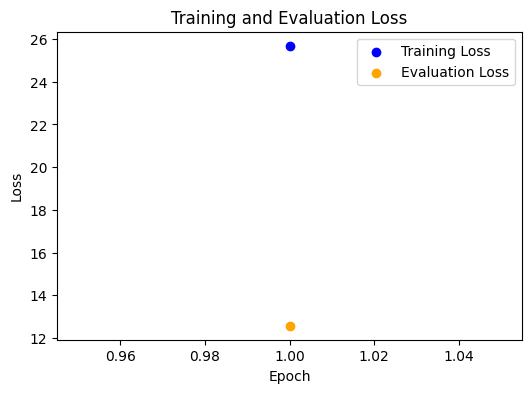

In [30]:
# Plotting the loss values
plt.figure(figsize=(6, 4))
plt.scatter(range(1,num_epochs+1), train_losses, label="Training Loss", color='blue')
plt.scatter(range(1,num_epochs+1), eval_losses, label="Evaluation Loss", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

## Inference
Here you can load a model from a pt file that provide for your convenience.  So, If the model training on CPU takes too long, you can load this file and continue the lab.


In [31]:
'''model = BERT(vocab_size, d_model, n_layers, heads, dropout)  # Ensure these parameters match the original model's
!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/H04Cs7O75aOfmJ4YP2HdPw.pt'
model.load_state_dict(torch.load('H04Cs7O75aOfmJ4YP2HdPw.pt',map_location=torch.device('cpu')))
model.to(device)'''

"model = BERT(vocab_size, d_model, n_layers, heads, dropout)  # Ensure these parameters match the original model's\n!wget 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/H04Cs7O75aOfmJ4YP2HdPw.pt'\nmodel.load_state_dict(torch.load('H04Cs7O75aOfmJ4YP2HdPw.pt',map_location=torch.device('cpu')))\nmodel.to(device)"

To evaluate the performance of a pretrained BERT model in predicting whether a second sentence follows the first, a function called `predict_nsp` is defined. The function operates as follows:

1. Tokenization: The input sentences are tokenized using the `tokenizer.encode_plus` method, which returns a dictionary of tokenized inputs. These tokenized inputs are then converted into tensors and moved to the appropriate device for processing.

2. Prediction: The BERT model is utilized to make predictions by passing the token and segment tensors as input.

3. Logits Manipulation: The first element of the logits tensor is selected and unsqueezed to add an extra dimension, resulting in a shape of `[1, 2]`.

4. Probability and Prediction: The logits are passed through a softmax function to obtain probabilities, and the prediction is obtained by taking the argmax.

5. Result Interpretation: The prediction is interpreted and returned as a string, indicating whether the second sentence follows the first or not.

6. Example Usage: An example usage of the `predict_nsp` function is provided, demonstrating how two example sentences can be passed to the function along with a BERT model and tokenizer. The result is printed, indicating whether the second sentence follows the first based on the model's prediction.

By utilizing the `predict_nsp` function, the performance of the pretrained BERT model in determining the relationship between two sentences can be assessed.


In [32]:
# Initialize the tokenizer with the BERT model's vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.eval()

def predict_nsp(sentence1, sentence2, model, tokenizer):
    # Tokenize sentences with special tokens
    tokens = tokenizer.encode_plus(sentence1, sentence2, return_tensors="pt")
    tokens_tensor = tokens["input_ids"].to(device)
    segment_tensor = tokens["token_type_ids"].to(device)

    # Predict
    with torch.no_grad():
        # Assuming the model returns NSP predictions first
        nsp_prediction, _ = model(tokens_tensor, segment_tensor)
        # Select the first element (first sequence) of the logits tensor
        first_logits = nsp_prediction[0].unsqueeze(0)  # Adds an extra dimension, making it [1, 2]
        logits = torch.softmax(first_logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()

    # Interpret the prediction
    return "Second sentence follows the first" if prediction == 1 else "Second sentence does not follow the first"

# Example usage
sentence1 = "The cat sat on the mat."
sentence2 = "It was a sunny day"

print(predict_nsp(sentence1, sentence2, model, tokenizer))

Second sentence does not follow the first


A function is defined to perform Masked Language Modeling (MLM) using a pretrained BERT model. The function operates as follows:

1. Tokenization: The input sentence is tokenized using the tokenizer and converted into token IDs, including the special tokens. The tokenized sentence is stored in the `tokens_tensor` variable.

2. Segment Labels: Dummy segment labels filled with zeros are created and stored as `segment_labels`.

3. Prediction: The BERT model is used to make predictions by passing the token tensor and segment labels as input. The MLM logits are extracted as `predictions`.

4. Mask Token Index: The position of the [MASK] token is identified using the `nonzero` method and stored in the `mask_token_index` variable. Note that all tokens except the mask token are zero-padded.

5. Predicted Index: The predicted index for the [MASK] token is obtained by taking the argmax of the MLM logits at the corresponding position.

6. Token Conversion: The predicted index is converted back to a token using the `convert_ids_to_tokens` method of the tokenizer.

7. Replaced Sentence: The original sentence is replaced with the predicted token at the position of the [MASK] token, resulting in the predicted sentence.


In [33]:
def predict_mlm(sentence, model, tokenizer):
    # Tokenize the input sentence and convert to token IDs, including special tokens
    inputs = tokenizer(sentence, return_tensors="pt")
    tokens_tensor = inputs.input_ids

    # Create dummy segment labels filled with zeros, assuming it's needed by your model
    segment_labels = torch.zeros_like(tokens_tensor)

    with torch.no_grad():
        # Forward pass through the model, now correctly handling the output tuple
        output_tuple = model(tokens_tensor, segment_labels)

        # Assuming the second element of the tuple contains the MLM logits
        predictions = output_tuple[1]  # Adjusted based on your model's output

        # Identify the position of the [MASK] token
        mask_token_index = (tokens_tensor == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # Get the predicted index for the [MASK] token from the MLM logits
        predicted_index = torch.argmax(predictions[0, mask_token_index.item(), :], dim=-1)
        predicted_token = tokenizer.convert_ids_to_tokens([predicted_index.item()])[0]

        # Replace [MASK] in the original sentence with the predicted token
        predicted_sentence = sentence.replace(tokenizer.mask_token, predicted_token, 1)

    return predicted_sentence


# Example usage
sentence = "The cat sat on the [MASK]."
print(predict_mlm(sentence, model, tokenizer))

The cat sat on the [unused4].


Congratualtions! You've just learnt how to create a tiny BERT model and trained it for a few epochs. for the model to generate accurate result, you will need to train it on huge datasets for more epochs and maybe increase the model size.


# Exercises
Now you have preatined our own Baby BERT and evaluated it now to see the difference lets use a pretrained BERT model to predict for few examples as above. 

**Note: Since the actual BERT is trained with a lot more data and epochs, its performance should be much better than the model you just built.**


## Exercise 1: Next Sentence Prediction (NSP) with BERT

1. **Load the BERT pretrained model**: Import `BertForPreTraining` and `BertTokenizer` from `transformers`, and load the 'bert-base-uncased' pretrained model and tokenizer.
2. **Prepare text input**: Encode a pair of sentences using the loaded tokenizer.
3. **Perform NSP**: Pass the encoded input through the model and interpret the `seq_relationship_logits` to determine if the model predicts the sentences as consecutive.


In [34]:
from transformers import BertForPreTraining, BertTokenizer
import torch

# Write your code here
model = BertForPreTraining.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

text1 = "The cat sat on the mat"
text2 = "It was a sunny day"

text = tokenizer(text1, text2, return_tensors="pt")

with torch.no_grad():
    output = model(**text)

output.seq_relationship_logits

print("NSP output shape is ", output.seq_relationship_logits.shape)

print("NSP output is ", torch.argmax(output.seq_relationship_logits, dim=1).item())

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

NSP output shape is  torch.Size([1, 2])
NSP output is  0


<details>
    <summary>Click here for Solution</summary>

```python
# Load pretrained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pretrained model (weights)
model = BertForPreTraining.from_pretrained('bert-base-uncased')
# Prepare text pair for NSP
text_1 = "The cat sat on the mat"
text_2 = "It was a sunny day"
# Encode text
inputs = tokenizer(text_1, text_2, return_tensors="pt")

# Predict
with torch.no_grad():
    outputs = model(**inputs, next_sentence_label=torch.LongTensor([1]))
    nsp_logits = outputs.seq_relationship_logits

# Interpret the result for NSP
if torch.argmax(nsp_logits, dim=-1).item() == 0:
    print("The model thinks these sentences are NOT consecutive.")
else:
    print("The model thinks these sentences are consecutive.")
```

</details>


## Exercise 2: Masked Language Modeling (MLM) with BERT
1. **Initialize the model and tokenizer**:
   Load `BertForPreTraining` and `BertTokenizer` from the `transformers` library using the 'bert-base-uncased' model.
2. **Prepare the masked sentence**:
   Write a sentence and replace one word with `[MASK]`. For example, "The capital of France is [MASK]."
3. **Tokenize and predict**:
   Tokenize the masked sentence with `BertTokenizer.` Then, input it to `BertForPreTraining` and use the `prediction_logits` to find the most probable token that fits the mask.
4. **Display the prediction**:
   Convert the predicted token ID back to a token string and print out the predicted word.


In [38]:
from transformers import BertForPreTraining, BertTokenizer
import torch

# Write your code here
text = tokenizer("The capital of France is [MASK].", return_tensors="pt")["input_ids"]

with torch.no_grad():
    output = model(input_ids = text)

output = output.prediction_logits

index = torch.argmax(output[0, text[0] == tokenizer.mask_token_id]).item()

print("MLM prediction is " , tokenizer.convert_ids_to_tokens([index]))

MLM prediction is  ['paris']


<details>
    <summary>Click here for Solution</summary>

```python
from transformers import BertForPreTraining, BertTokenizer
import torch

# Load pretrained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pretrained model (weights)
model = BertForPreTraining.from_pretrained('bert-base-uncased')

# Prepare text with masked token
masked_text = "The capital of France is [MASK]."
# Tokenize and prepare for the model: Convert to tokens and add special tokens
input_ids = tokenizer(masked_text, return_tensors="pt")["input_ids"]

# Predict all tokens
with torch.no_grad():
    outputs = model(input_ids=input_ids)
    predictions = outputs.prediction_logits

# Confirm we were able to predict 'Paris' as the masked token
predicted_index = torch.argmax(predictions[0, input_ids[0] == tokenizer.mask_token_id]).item()
predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])

print(f"Predicted token: {predicted_token}")
```

</details>


## Authors

[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS at Dalhousie University. He has previous experience in Natural Language Processing and as a Data Scientist.

## Contributors

[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a Ph.D. candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.


## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)
- [Mastering BERT Model: Building it from Scratch with Pytorch](https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891)


Copyright © IBM Corporation. All rights reserved.
